In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gekko import GEKKO

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')
from plotter import Plot



### Load Data

In [2]:

data_dir = '../data/'
df = pd.read_excel(os.path.join(data_dir, 'virtual_room_vent_simulation.xlsx'), sheet_name='calculation')


start_point = 0
end_point = 3000

occupancy_arr = np.asarray(df['occupancy'].iloc[start_point:end_point])             #[PP]
c_co2_meas_arr = np.asarray(df['cCO2_ppm'].iloc[start_point:end_point])             #[ppm/s]
valve_fraction_arr = np.asarray(df['valve_frac'].iloc[start_point:end_point])       #[-]

delta_t = 900      #[s]


### Gekko Model - Initialize

In [3]:
m = GEKKO(remote=False)
m.time = np.linspace(delta_t, len(valve_fraction_arr) * delta_t, len(valve_fraction_arr))  #[s]

### Gekko - Parameter

In [4]:
# Constant Variable
MET = m.Param(value= 3.5 * 77.5 / (60*1e6))             #[m3/(s.pp)]
v_room = m.Param(value=90)                              #[m3]
v_vent_max = m.Param(value=500)                         #[m3/h]
u_wind = m.Param(value=3)                               #[m/s]
c_co2_ext = m.Param(value=415)                          #[ppm]


# Manipulated Variable (input of the model- measuered data)
c_co2_meas = m.MV(value=c_co2_meas_arr)                     #[ppm/s]
c_co2_meas.STATUS = 0
c_co2_meas.FSTATUS = 1

occupancy = m.MV(value = occupancy_arr)                     #[pp]
occupancy.STATUS = 0
occupancy.FSTATUS = 1

valve_fraction = m.MV(value=valve_fraction_arr)             #[-]
valve_fraction.STATUS = 0
valve_fraction.FSTATUS = 1


# Fixed Variable (model parameter)
A_wind = m.FV(value=0.001)                                  #[m2]
A_wind.STATUS = 1
A_wind.FSTATUS = 0

# Control Varibale (prediction variable)
c_co2_sim = m.CV(value=c_co2_meas)                          #[ppm/s]
c_co2_sim.STATUS = 1
c_co2_sim.FSTATUS = 1

### Gekko - Equation

In [5]:
v_wind = m.Intermediate(u_wind * A_wind)                                                                #[m3/s]
v_vent = m.Intermediate(v_vent_max * valve_fraction/ (60*60))                                           #[m3/s]
c_co2_loss_dt = m.Intermediate((v_vent + v_wind) / v_room * (c_co2_sim - c_co2_ext))                    #[ppm/s]
v_co2_gain = m.Intermediate(occupancy * 1.5 * MET)                                                      #[m3/s]
c_co2_gain_dt = m.Intermediate(v_co2_gain / v_room * 1e6)                                               #[ppm/s]
m.Equation(c_co2_sim.dt() == c_co2_gain_dt - c_co2_loss_dt)                                             #[ppm/s]

### Gekko - Solver setting

In [6]:
m.options.IMODE = 5
m.options.EV_TYPE = 1           #specific objective function (L1-norm vs L2-norm)
m.options.NODES = 2
m.solve(disp=False)

In [7]:
# create empty dataframe for results of all homes
df.head()

,Unnamed: 0,room_id,timestamp_local,dayofweek,time,lookup_daytime,occupancy,vCO2_gain_m3_per_s,vCO2_gain_ppm/s,cCO2__minus_cCO2set,v_CO2_loss_min_ppm/s,is_vent_needed,vent_max_m3_per_h,ACPH_max,vCO2_loss_max_ppm/s,valve_frac,v_CO2_loss_ppm/s,cCO2_ppm,dCO2_ppm
0,0,886307,2022-01-03 00:00:00,0,00:00:00,00:00:10,0,0.0,0.0,-385.0,0.0,False,0,0.0,0.0,0.0,0.0,415.0,0.0
1,1,886307,2022-01-03 00:15:00,0,00:15:00,00:15:10,0,0.0,0.0,-385.0,0.0,False,0,0.0,0.0,0.0,0.0,415.0,0.0
2,2,886307,2022-01-03 00:30:00,0,00:30:00,00:30:10,0,0.0,0.0,-385.0,0.0,False,0,0.0,0.0,0.0,0.0,415.0,0.0
3,3,886307,2022-01-03 00:45:00,0,00:45:00,00:45:10,0,0.0,0.0,-385.0,0.0,False,0,0.0,0.0,0.0,0.0,415.0,0.0
4,4,886307,2022-01-03 01:00:00,0,01:00:00,01:00:10,0,0.0,0.0,-385.0,0.0,False,0,0.0,0.0,0.0,0.0,415.0,0.0


In [8]:
df['Simulated_co2_ppm_per_s'] =  list(c_co2_sim.value)


### Result

In [9]:
print('effective area  that wind blows through [cm2]: ', A_wind.value[0] * 1e4)

effective area  that wind blows through [cm2]:  8.9666506862


### Result Visualization

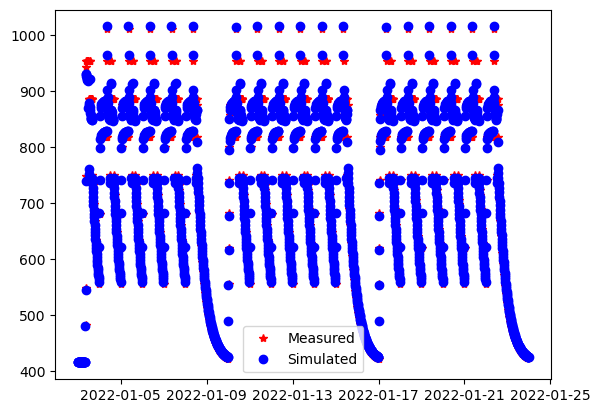

In [10]:
time_recorded = df['timestamp_local'].iloc[start_point:end_point]
plt.plot(time_recorded, c_co2_meas, 'r*', label='Measured')
plt.plot(time_recorded, c_co2_sim.value, 'bo', label='Simulated')
plt.legend()
plt.show()


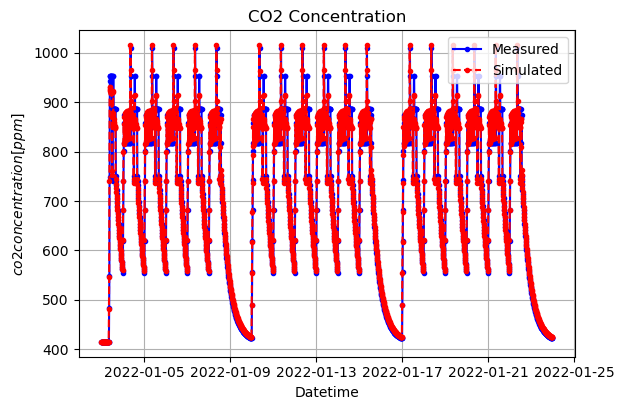

In [11]:
Plot.co2_concentration_virtual_ds(title = 'CO2 Concentration', df = df)
